In [1]:
import os
import dynamics
from packaging import version
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
import glob
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as ptl
from models import HigherOrderModel
from hypergraphs import *
from pysindy.differentiation import FiniteDifference, SmoothedFiniteDifference
from utils import return_single_result, bar_plot

/home/scholkemper/publication-2023-learning-the-effective-order-of-a-hypergraph-dynamical-system/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-09-28 19:59:58,154	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2023-09-28 19:59:58,272	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2023-09-28 19:59:58.623924: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-28 19:59:58.665562: I 

## Figure 3 (b): Trajectory evaluation of model trained on point-based dataset

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


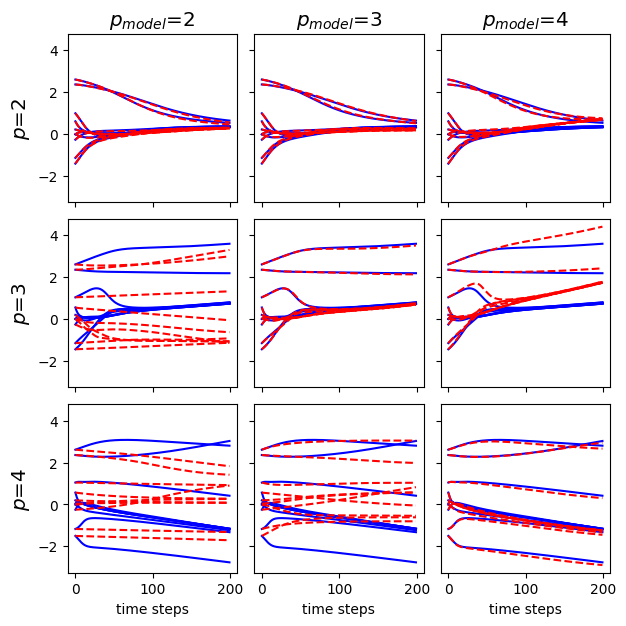

In [2]:
device = torch.device('cuda:0')
order = 4
dataset_network_size = 20
dataset_sample_size = 500
number_time_steps = 200
time_delta = 0.01
num_folds = 10
non_linear = True
test_network_size = 10

initialisations = {
    'Kuramoto': "-pipiuniform",
  #  'SI': "01uniform",
  #  "MCMI": "skewed",
  #  'Diffusion': "-11uniform"
}

functions = {
     'Kuramoto': dynamics.KuramotoLiftingFunction,
  #  'SI': dynamics.SILiftingFunction,
 #"MCMI": dynamics.MCMILiftingFunction,
  #  'Diffusion': dynamics.DiffusionLiftingFunction
}

trainer = ptl.Trainer()
agg='min'

fig, axs = plt.subplots(3, 3, figsize=[7, 7], sharey=True, sharex=True)
cols = [r'$p_{model}$='+str(col) for col in [2,3,4]]
rows = [r'$p$='+str(row) for row in [2, 3, 4]]
for ax, col in zip(axs[0], cols):
    ax.set_title(label=col,fontsize='x-large')

for ax, row in zip(axs[:, 0], rows):
    ax.set_ylabel(row, rotation=90, size='x-large')

for ax, col in zip(axs[2], cols):
    ax.set_xlabel("time steps")

for name in functions:
   # X = initialise_X(test_network_size, initialisations[name])
    X = pt.tensor([[2.3591912],
                   [2.5983863],
                   [1.0255902],
                   [-1.1813295],
                   [-1.4675621],
                   [0.00413378],
                   [0.6782063],
                   [0.2203815],
                   [-0.06120097],
                   [-0.3138196]])
    for i,nonlinear_cut_data in enumerate([2,3,4]):
        result = []
        for j,nonlinear_cut_model in enumerate([2,3,4]):
            dataset_network_size = 20
            lifting_func = functions[name](
            order, nonlinear_cut_data)
            path = 'our_results/cross_validation/ERHypergraphXGI/data_' + str(dataset_sample_size) + '_' + str(
                dataset_network_size) + '_' + str(order) + '_' + lifting_func.name() +"_"+ initialisations[name] + "/"+"model_non_linear"+str(non_linear) + '_'+str(nonlinear_cut_model)+'_fold'+str(1)
            filename = np.random.choice(os.listdir(path + "/checkpoints/"))
            model = HigherOrderModel.load_from_checkpoint(path + "/checkpoints/"+filename)
            model.to(device)
            model.eval()

            dataset_name = 'test/ERHypergraph'

            edges = [[0, 1], [7,8], [0,9], [5, 6], [1, 2, 3],[3,4,5],[5,6,7,8] ,[2, 3, 4, 5], [6, 7, 8, 9]]

            data_generator = Hypergraph_Trajectory_Generator(dataset_name, test_network_size, order, edges, X, lifting_func, number_time_steps, time_delta)
            traj_data = data_generator.data

            t = np.linspace(0, number_time_steps*time_delta, number_time_steps)
            y_hat_traj = []
            with pt.no_grad():
                  trajectory_real = traj_data.y
                  trajectory_predicted = [traj_data.y[0].cuda()]
                  dense_L = traj_data.hyper_edge_index
                  number_time_steps = len(traj_data.y)
                  for t in range(number_time_steps-1):
                      y_hat = model(
                          trajectory_predicted[-1], traj_data.hyper_edge_index)
                      trajectory_predicted.append(
                          pt.add(trajectory_predicted[-1], pt.mul(time_delta, y_hat)))
            axs[i][j].plot(torch.stack(trajectory_real).squeeze().numpy(), color="b", label="true")
            axs[i][j].plot(torch.stack(trajectory_predicted).squeeze().cpu().numpy(), color="r", linestyle = "--",label="predicted")
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.savefig("./plots/derivatives/trajectories.pdf",
            bbox_inches='tight')

## Figure 3 (d): Trajectory evaluation of model trained on trajectory-based dataset

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


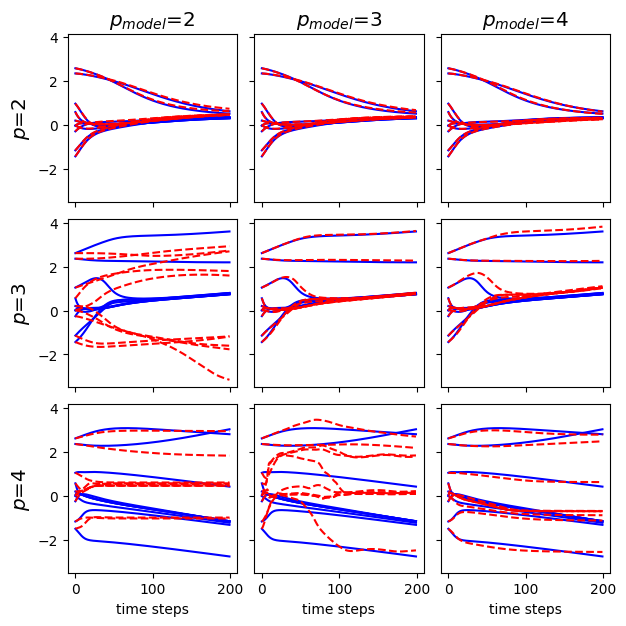

In [3]:
device = torch.device('cuda:0')
dataset_name = 'data/ERHypergraph'
order = 4
dataset_network_size = 20
dataset_sample_size = 25
number_time_steps = 200
time_delta = 0.01
num_folds = 10
non_linear = True
network_size = 10

initialisations = {
    'Kuramoto': "-pipiuniform",
  #  'SI': "01uniform",
   # "MCMI": "skewed",
  #  'Diffusion': "-11uniform"
}

functions = {
     'Kuramoto': dynamics.KuramotoLiftingFunction,
  #  'SI': dynamics.SILiftingFunction,
  #  "MCMI": dynamics.MCMILiftingFunction,
  #  'Diffusion': dynamics.DiffusionLiftingFunction
}

trainer = ptl.Trainer()
agg='min'

fig, axs = plt.subplots(3, 3, figsize=[7, 7], sharey=True, sharex=True)
cols = [r'$p_{model}$='+str(col) for col in [2, 3, 4]]
rows = [r'$p$='+str(row) for row in [2, 3, 4]]
for ax, col in zip(axs[0], cols):
    ax.set_title(col,fontsize='x-large')

for ax, row in zip(axs[:, 0], rows):
    ax.set_ylabel(row, rotation=90, size='x-large')

for ax, col in zip(axs[2], cols):
    ax.set_xlabel("time steps")



for name in functions:
    #X = initialise_X(network_size, initialisations[name])
    X = pt.tensor([[2.3591912],
                   [2.5983863],
                   [1.0255902],
                   [-1.1813295],
                   [-1.4675621],
                   [0.00413378],
                   [0.6782063],
                   [0.2203815],
                   [-0.06120097],
                   [-0.3138196]])
    for i,nonlinear_cut_data in enumerate([2,3,4]):
        result = []
        for j,nonlinear_cut_model in enumerate([2,3,4]):
            dataset_network_size = 20
            lifting_func = functions[name](
            order, nonlinear_cut_data)
            path = 'our_results/cross_validation/ERHypergraphXGI/trajectories/data_' + str(dataset_sample_size) + '_' + str(
                dataset_network_size) + '_' + str(order) + '_' + lifting_func.name() +"_"+ initialisations[name] + "/"+"model_non_linear"+str(non_linear) + '_'+str(nonlinear_cut_model)+'_fold'+str(1)
            filename = np.random.choice(os.listdir(path + "/checkpoints/"))
            model = HigherOrderModel.load_from_checkpoint(path + "/checkpoints/"+filename)
            model.to(device)
            model.eval()

            dataset_name = 'test/ERHypergraph/trajectories'

            edges = [[0, 1], [7,8], [0,9], [5, 6], [1, 2, 3],[3,4,5],[5,6,7,8] ,[2, 3, 4, 5], [6, 7, 8, 9]]

            data_generator = Hypergraph_Trajectory_Generator(dataset_name, network_size, order, edges, X, lifting_func, number_time_steps, time_delta)
            traj_data = data_generator.data

            t = np.linspace(0, number_time_steps*time_delta, number_time_steps)
            y_hat_traj = []
            with pt.no_grad():
                  trajectory_real = traj_data.y
                  trajectory_predicted = [traj_data.y[0].cuda()]
                  dense_L = traj_data.hyper_edge_index
                  number_time_steps = len(traj_data.y)
                  for t in range(number_time_steps-1):
                      y_hat = model(
                          trajectory_predicted[-1], traj_data.hyper_edge_index)
                      trajectory_predicted.append(
                          pt.add(trajectory_predicted[-1], pt.mul(time_delta, y_hat)))
            axs[i][j].plot(torch.stack(trajectory_real).squeeze().numpy(), color="b", label="true")
            axs[i][j].plot(torch.stack(trajectory_predicted).squeeze().cpu().numpy(), color="r", linestyle = "--",label="predicted")
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.savefig("./plots/derivatives/trajectories_traj_model.pdf",
            bbox_inches='tight')

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


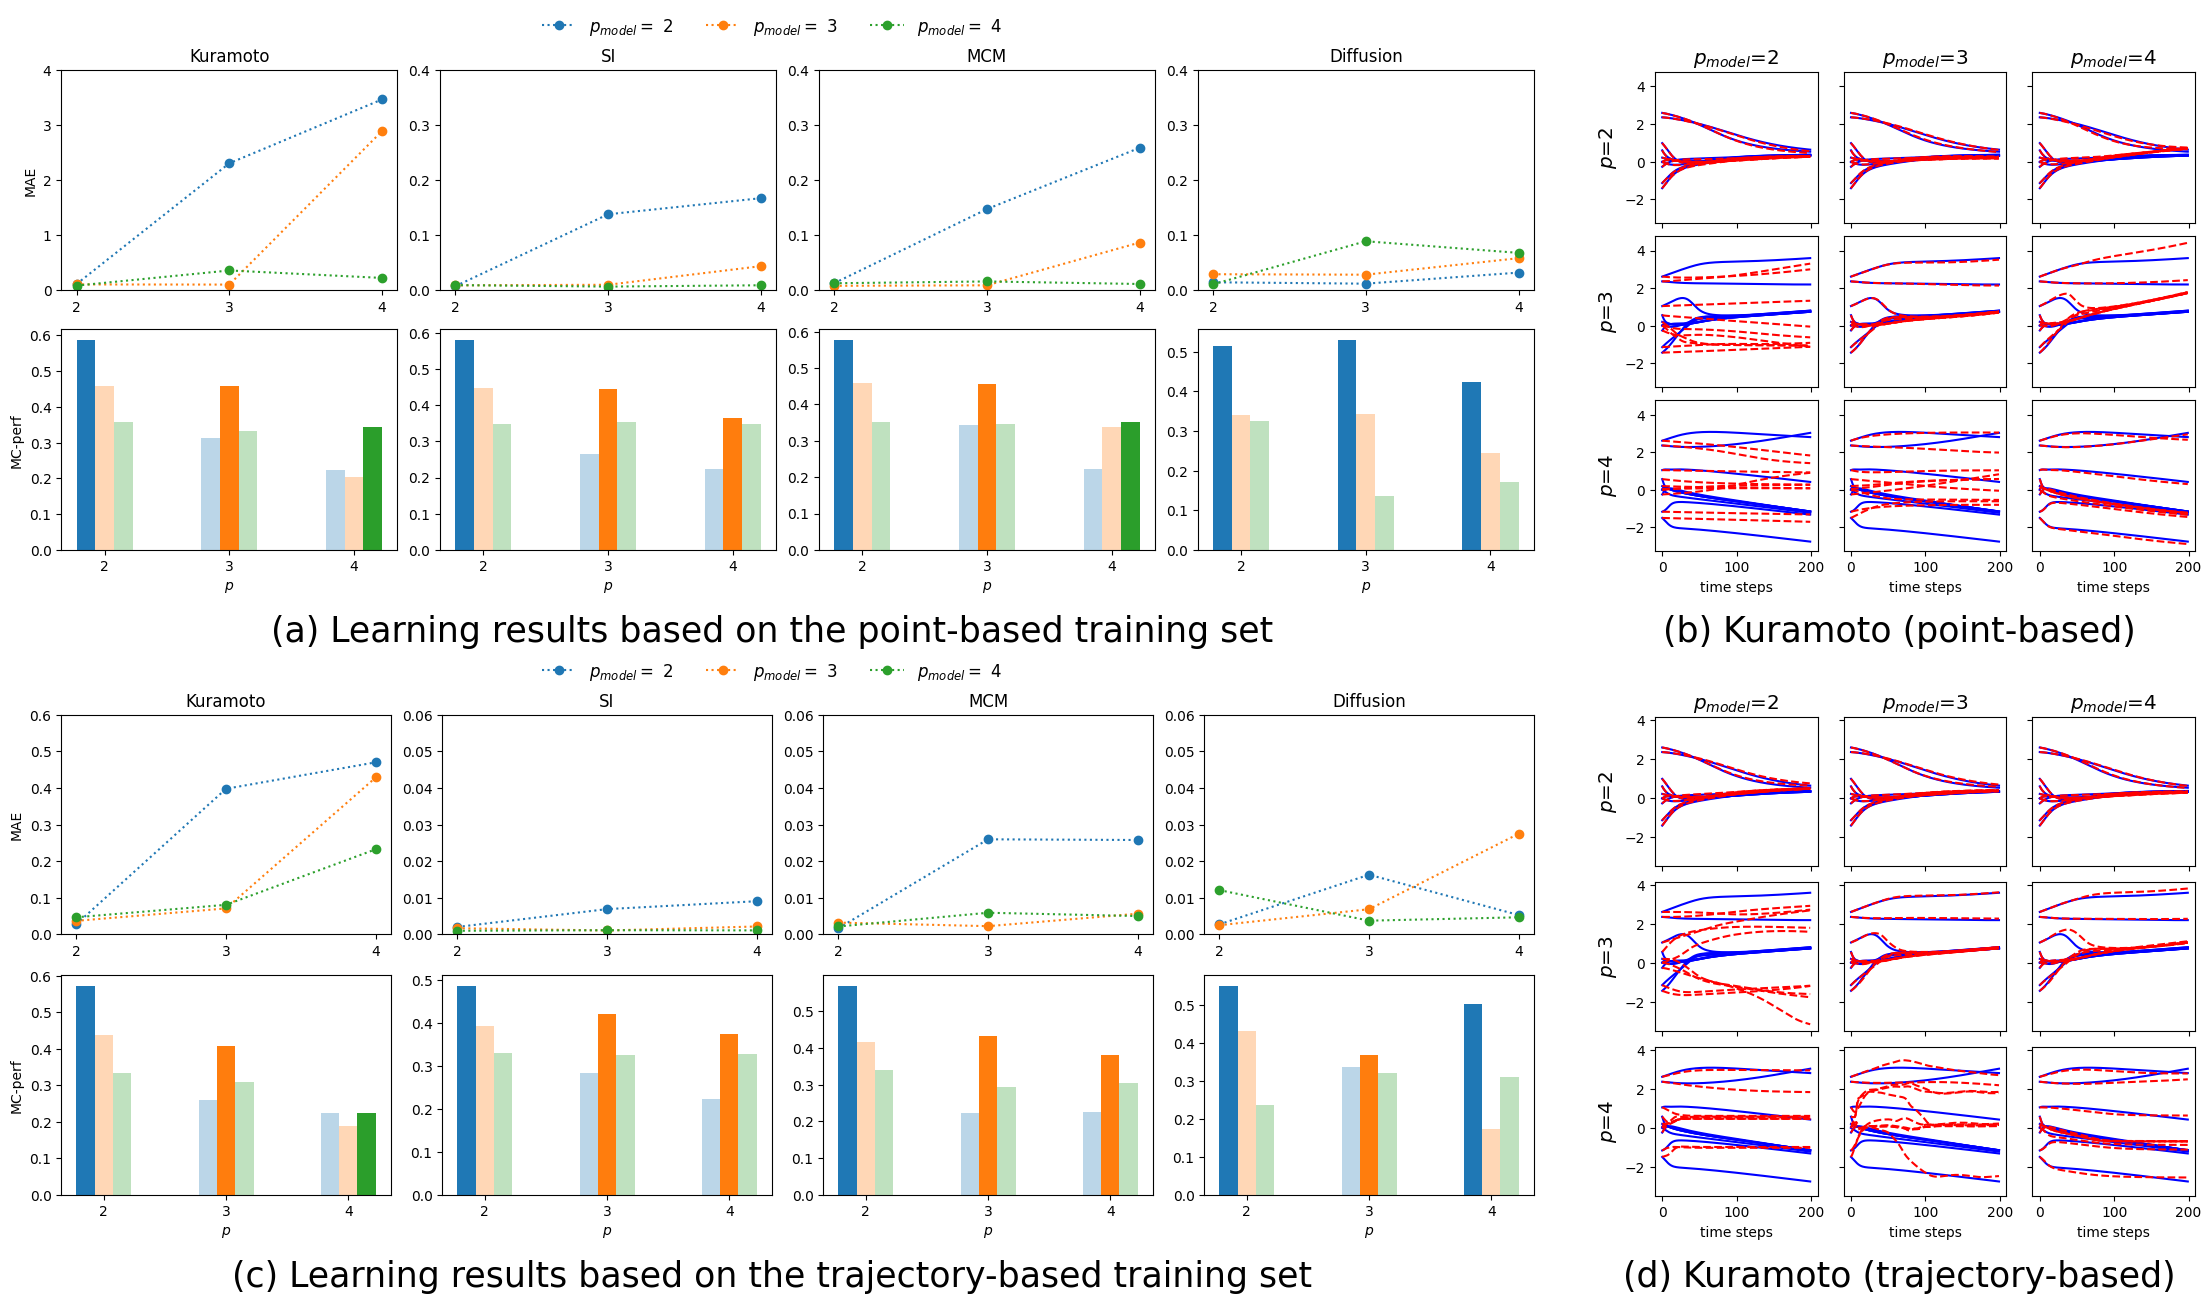

In [7]:
fig = plt.figure(figsize=(22, 12), constrained_layout=True)
subfigs = fig.subfigures(2, 2,wspace=0.05,hspace=0.15, width_ratios=[2.5, 1], height_ratios=[1, 1])







dataset_name = 'ERHypergraphXGI'
order = 4
dataset_network_size = 20
dataset_sample_size = 500
num_folds = 10
non_linear = True
alphas = {
    'Kuramoto': [([1., .3, .3]), ([.3, 1., .3]), ([.3, .3, 1.])],
    'SI': [([1., .3, .3]), ([.3, 1., 1.]), ([.3, .3, .3])],
    "MCMI": [([1., .3, .3]), ([.3, 1., .3]), ([.3, .3, 1.])],
    'Diffusion': [([1., 1., 1.]), ([.3, .3, .3]), ([.3, .3, .3])]
}
initialisations = {
    'Kuramoto': "-pipiuniform",
    'SI': "01uniform",
    "MCMI": "skewed",
    'Diffusion': "-11uniform"
}

functions = {
     'Kuramoto': dynamics.KuramotoLiftingFunction,
     'SI': dynamics.SILiftingFunction,
    "MCMI": dynamics.MCMILiftingFunction,
    'Diffusion': dynamics.DiffusionLiftingFunction
}

agg='min'

axs = subfigs[0,0].subplots(2,4)
axs[0, 0].set_ylabel("MAE")
axs[1, 0].set_ylabel("MC-perf")
axs[0, 0].set_title("Kuramoto")
axs[0, 0].set_ylim(0, 4)
axs[0, 1].set_title("SI")
axs[0, 1].set_ylim(0, 0.4)
axs[0, 2].set_title("MCM")
axs[0, 2].set_ylim(0, 0.4)
axs[0, 3].set_title("Diffusion")
axs[0, 3].set_ylim(0, 0.4)
for i, name in enumerate(functions):
    result = np.zeros((3, 3))
    scaled_result = []
    for row, nonlinear_cut_model in enumerate([2, 3, 4]):
        for column, nonlinear_cut_data in enumerate([2, 3, 4]):
            lifting_func = functions[name](
                order, nonlinear_cut_data)
            data_dir = 'our_results/cross_validation/'+dataset_name+'/data_' + str(dataset_sample_size) + '_' + str(
                dataset_network_size) + '_' + str(order) + '_' + lifting_func.name() + "_" + initialisations[name]
            result[row, column] = return_single_result(
                non_linear, nonlinear_cut_model, agg, data_dir, num_folds)
        axs[0][i].plot(result[row, :], label=r'$p_{model}=$ '+str(nonlinear_cut_model),
                           marker="o", linestyle="dotted")
    result = result / np.max(result)
    diff_min = np.zeros((3, 3))
    for row, nonlinear_cut_model in enumerate([2, 3, 4]):
        diff_min[row, :] = np.exp(-result[row, :])*np.exp(-(nonlinear_cut_model)/(4))
        max_values = np.amax(diff_min, axis=0)
        normalised_results = diff_min
    bar_plot(axs[1][i], normalised_results, name,alphas[name])
    axs[0][i].set_xticks([0, 1, 2], ['2', '3', '4'])
handles, labels = axs[0][i].get_legend_handles_labels()
subfigs[0,0].legend(handles, labels, frameon=False, loc='center',bbox_to_anchor=(0.5,1.03), ncol=5,fontsize=12)
subfigs[0,0].suptitle("(a) Learning results based on the point-based training set", y=-0.03, fontsize=25)




dataset_name = 'ERHypergraphXGI'
order = 4
dataset_network_size = 20
dataset_sample_size = 25
num_folds = 10
non_linear = True
alphas = {
    'Kuramoto': [([1., .3, .3]), ([.3, 1., .3]), ([.3, .3, 1.])],
    'SI': [([1., .3, .3]), ([.3, 1., 1.]), ([.3, .3, .3])],
    "MCMI": [([1., .3, .3]), ([.3, 1., 1.]), ([.3, .3, .3])],
    'Diffusion': [([1., .3, 1.]), ([.3, 1., .3]), ([.3, .3, .3])]
}
initialisations = {
    'Kuramoto': "-pipiuniform",
    'SI': "01uniform",
    "MCMI": "skewed",
    'Diffusion': "-11uniform"
}

functions = {
     'Kuramoto': dynamics.KuramotoLiftingFunction,
    'SI': dynamics.SILiftingFunction,
    "MCMI": dynamics.MCMILiftingFunction,
    'Diffusion': dynamics.DiffusionLiftingFunction
}

agg='min'

axs = subfigs[1,0].subplots(2,4)
axs[0, 0].set_ylabel("MAE")
axs[1, 0].set_ylabel("MC-perf")
axs[0, 0].set_title("Kuramoto")
axs[0, 0].set_ylim(0, 0.6)
axs[0, 1].set_title("SI")
axs[0, 1].set_ylim(0, 0.06)
axs[0, 2].set_title("MCM")
axs[0, 2].set_ylim(0, 0.06)
axs[0, 3].set_title("Diffusion")
axs[0, 3].set_ylim(0, 0.06)
for i, name in enumerate(functions):
    result_old = np.zeros((3, 3))
    scaled_result = []
    for row, nonlinear_cut_model in enumerate([2, 3, 4]):
        for column, nonlinear_cut_data in enumerate([2, 3, 4]):
            lifting_func = functions[name](
                order, nonlinear_cut_data)
            data_dir = 'our_results/cross_validation/'+dataset_name+'/trajectories/data_' + str(dataset_sample_size) + '_' + str(
                dataset_network_size) + '_' + str(order) + '_' + lifting_func.name() + "_" + initialisations[name]
            path = data_dir + "/"+"model_non_linear"+str(non_linear) + '_'+str(nonlinear_cut_model)+'_fold'+str(1)
            num_samples=100
            time_steps=100
            test_network_size=20
            MSE=False
    result_old = np.load(path+'/mean_traj_error_'+str(num_samples)+"_" + str(time_steps)+"_"+str(test_network_size)+".npy")
    result = result_old / np.max(result_old)
    diff_min = np.zeros((3, 3))
    for row, nonlinear_cut_model in enumerate([2, 3, 4]):
        axs[0][i].plot(result_old[row, :], label=r'$p_{model}=$ '+str(nonlinear_cut_model),
                           marker="o", linestyle="dotted")
        diff_min[row, :] = np.exp(-result[row, :])*np.exp(-(nonlinear_cut_model)/(4))
        max_values = np.amax(diff_min, axis=0)

        normalised_results = diff_min
    bar_plot(axs[1][i], normalised_results, name,alphas[name])
    axs[0][i].set_xticks([0, 1, 2], ['2', '3', '4'])
handles, labels = axs[0][i].get_legend_handles_labels()
subfigs[1,0].legend(handles, labels, frameon=False, loc='center',bbox_to_anchor=(0.5,1.03), ncol=5,fontsize=12)
subfigs[1,0].suptitle("(c) Learning results based on the trajectory-based training set", y=-0.03, fontsize=25)











device = torch.device('cuda:0')
order = 4
dataset_network_size = 20
dataset_sample_size = 500
number_time_steps = 200
time_delta = 0.01
num_folds = 10
non_linear = True
test_network_size = 10

initialisations = {
    'Kuramoto': "-pipiuniform",
  #  'SI': "01uniform",
  #  "MCMI": "skewed",
  #  'Diffusion': "-11uniform"
}

functions = {
     'Kuramoto': dynamics.KuramotoLiftingFunction,
  #  'SI': dynamics.SILiftingFunction,
 #"MCMI": dynamics.MCMILiftingFunction,
  #  'Diffusion': dynamics.DiffusionLiftingFunction
}

trainer = ptl.Trainer()
agg='min'

axs = subfigs[0,1].subplots(3, 3, sharey=True, sharex=True)
cols = [r'$p_{model}$='+str(col) for col in [2,3,4]]
rows = [r'$p$='+str(row) for row in [2, 3, 4]]
for ax, col in zip(axs[0], cols):
    ax.set_title(label=col,fontsize='x-large')

for ax, row in zip(axs[:, 0], rows):
    ax.set_ylabel(row, rotation=90, size='x-large')

for ax, col in zip(axs[2], cols):
    ax.set_xlabel("time steps")

for name in functions:
   # X = initialise_X(test_network_size, initialisations[name])
    X = pt.tensor([[2.3591912],
                   [2.5983863],
                   [1.0255902],
                   [-1.1813295],
                   [-1.4675621],
                   [0.00413378],
                   [0.6782063],
                   [0.2203815],
                   [-0.06120097],
                   [-0.3138196]])
    for i,nonlinear_cut_data in enumerate([2,3,4]):
        result = []
        for j,nonlinear_cut_model in enumerate([2,3,4]):
            dataset_network_size = 20
            lifting_func = functions[name](
            order, nonlinear_cut_data)
            path = 'our_results/cross_validation/ERHypergraphXGI/data_' + str(dataset_sample_size) + '_' + str(
                dataset_network_size) + '_' + str(order) + '_' + lifting_func.name() +"_"+ initialisations[name] + "/"+"model_non_linear"+str(non_linear) + '_'+str(nonlinear_cut_model)+'_fold'+str(1)
            filename = np.random.choice(os.listdir(path + "/checkpoints/"))
            model = HigherOrderModel.load_from_checkpoint(path + "/checkpoints/"+filename)
            model.to(device)
            model.eval()

            dataset_name = 'test/ERHypergraph'

            edges = [[0, 1], [7,8], [0,9], [5, 6], [1, 2, 3],[3,4,5],[5,6,7,8] ,[2, 3, 4, 5], [6, 7, 8, 9]]

            data_generator = Hypergraph_Trajectory_Generator(dataset_name, test_network_size, order, edges, X, lifting_func, number_time_steps, time_delta)
            traj_data = data_generator.data

            t = np.linspace(0, number_time_steps*time_delta, number_time_steps)
            y_hat_traj = []
            with pt.no_grad():
                  trajectory_real = traj_data.y
                  trajectory_predicted = [traj_data.y[0].cuda()]
                  dense_L = traj_data.hyper_edge_index
                  number_time_steps = len(traj_data.y)
                  for t in range(number_time_steps-1):
                      y_hat = model(
                          trajectory_predicted[-1], traj_data.hyper_edge_index)
                      trajectory_predicted.append(
                          pt.add(trajectory_predicted[-1], pt.mul(time_delta, y_hat)))
            axs[i][j].plot(torch.stack(trajectory_real).squeeze().numpy(), color="b", label="true")
            axs[i][j].plot(torch.stack(trajectory_predicted).squeeze().cpu().numpy(), color="r", linestyle = "--",label="predicted")
subfigs[0,1].suptitle("(b) Kuramoto (point-based)", y=-0.03, fontsize=25)



            
            
            
device = torch.device('cuda:0')
dataset_name = 'data/ERHypergraph'
order = 4
dataset_network_size = 20
dataset_sample_size = 25
number_time_steps = 200
time_delta = 0.01
num_folds = 10
non_linear = True
network_size = 10

initialisations = {
    'Kuramoto': "-pipiuniform",
  #  'SI': "01uniform",
   # "MCMI": "skewed",
  #  'Diffusion': "-11uniform"
}

functions = {
     'Kuramoto': dynamics.KuramotoLiftingFunction,
  #  'SI': dynamics.SILiftingFunction,
  #  "MCMI": dynamics.MCMILiftingFunction,
  #  'Diffusion': dynamics.DiffusionLiftingFunction
}

trainer = ptl.Trainer()
agg='min'

axs = subfigs[1,1].subplots(3, 3, sharey=True, sharex=True)
cols = [r'$p_{model}$='+str(col) for col in [2, 3, 4]]
rows = [r'$p$='+str(row) for row in [2, 3, 4]]
for ax, col in zip(axs[0], cols):
    ax.set_title(col,fontsize='x-large')

for ax, row in zip(axs[:, 0], rows):
    ax.set_ylabel(row, rotation=90, size='x-large')

for ax, col in zip(axs[2], cols):
    ax.set_xlabel("time steps")



for name in functions:
    #X = initialise_X(network_size, initialisations[name])
    X = pt.tensor([[2.3591912],
                   [2.5983863],
                   [1.0255902],
                   [-1.1813295],
                   [-1.4675621],
                   [0.00413378],
                   [0.6782063],
                   [0.2203815],
                   [-0.06120097],
                   [-0.3138196]])
    for i,nonlinear_cut_data in enumerate([2,3,4]):
        result = []
        for j,nonlinear_cut_model in enumerate([2,3,4]):
            dataset_network_size = 20
            lifting_func = functions[name](
            order, nonlinear_cut_data)
            path = 'our_results/cross_validation/ERHypergraphXGI/trajectories/data_' + str(dataset_sample_size) + '_' + str(
                dataset_network_size) + '_' + str(order) + '_' + lifting_func.name() +"_"+ initialisations[name] + "/"+"model_non_linear"+str(non_linear) + '_'+str(nonlinear_cut_model)+'_fold'+str(1)
            filename = np.random.choice(os.listdir(path + "/checkpoints/"))
            model = HigherOrderModel.load_from_checkpoint(path + "/checkpoints/"+filename)
            model.to(device)
            model.eval()

            dataset_name = 'test/ERHypergraph/trajectories'

            edges = [[0, 1], [7,8], [0,9], [5, 6], [1, 2, 3],[3,4,5],[5,6,7,8] ,[2, 3, 4, 5], [6, 7, 8, 9]]

            data_generator = Hypergraph_Trajectory_Generator(dataset_name, network_size, order, edges, X, lifting_func, number_time_steps, time_delta)
            traj_data = data_generator.data

            t = np.linspace(0, number_time_steps*time_delta, number_time_steps)
            y_hat_traj = []
            with pt.no_grad():
                  trajectory_real = traj_data.y
                  trajectory_predicted = [traj_data.y[0].cuda()]
                  dense_L = traj_data.hyper_edge_index
                  number_time_steps = len(traj_data.y)
                  for t in range(number_time_steps-1):
                      y_hat = model(
                          trajectory_predicted[-1], traj_data.hyper_edge_index)
                      trajectory_predicted.append(
                          pt.add(trajectory_predicted[-1], pt.mul(time_delta, y_hat)))
            axs[i][j].plot(torch.stack(trajectory_real).squeeze().numpy(), color="b", label="true")
            axs[i][j].plot(torch.stack(trajectory_predicted).squeeze().cpu().numpy(), color="r", linestyle = "--",label="predicted")
subfigs[1,1].suptitle("(d) Kuramoto (trajectory-based)", y=-0.03, fontsize=25)
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.savefig("./plots/derivatives/combined_pointwise_and_trajetories.pdf",
            bbox_inches='tight')
